<a href="https://colab.research.google.com/github/Himagination/TensorFlow_Developer/blob/main/05_FineTuning_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Apr 14 03:15:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper functions

Import helper_functions.py from Github.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-14 03:15:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-14 03:15:56 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get data

- Use pretrained models within `tf.keras.applications`

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-04-14 03:15:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.208, 142.250.73.208, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   264MB/s    in 0.6s    

2022-04-14 03:15:59 (264 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
# creating training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                            image_size=IMG_SIZE, 
                                                                            label_mode="categorical", 
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                                image_size=IMG_SIZE, 
                                                                label_mode="categorical", 
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 2.00000000e+00]
   [0.00000000e+00 9.28571701e-01 2.92857170e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   ...
   [0.00000000e+00 1.00000000e+00 5.21426392e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 2.85714293e+00]
   [0.00000000e+00 9.28571701e-01 3.78571463e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   ...
   [0.00000000e+00 1.00000000e+00 5.55100775e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 4.00000000e+00]
   [0.00000000e+00 9.28571701e-01 4.92857170e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   ...
   [0.00000000e+00 1.00000000e+00 6.00000000e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]
   [0.00000000e+00 1.00000000e+00 5.00000000e+00]]

  ...

  [[8.81634045e+00 8.81634045e+00 8.81634045e+00]
   [1

## Model 0: Building a transfer learning feature extraction model using Keras Functional API

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create Inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), 
                               name="Input_layer")

# 4. Pas the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 5. Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 6. Create output activation layer
outputs = tf.keras.layers.Dense(10, 
                                activation="softmax", 
                                name="output_layer")(x)

# 7. Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 9. Fit the model
history_0 = model_0.fit(train_data_10_percent, 
                        epochs=5, 
                        steps_per_epoch=len(train_data_10_percent), 
                        validation_data=test_data, 
                        validation_steps=int(0.25*len(test_data)), 
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                               experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220414-031612
Epoch 1/5
24/24 [==============================] - 22s 230ms/step - loss: 1.9051 - accuracy: 0.4200 - val_loss: 1.3162 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 4s 147ms/step - loss: 1.1395 - accuracy: 0.7520 - val_loss: 0.8753 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 4s 147ms/step - loss: 0.8297 - accuracy: 0.8133 - val_loss: 0.7188 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 4s 147ms/step - loss: 0.6924 - accuracy: 0.8453 - val_loss: 0.6482 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 5s 183ms/step - loss: 0.5803 - accuracy: 0.8720 - val_loss: 0.5728 - val_accuracy: 0.8734


In [13]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6104 - accuracy: 0.8456


[0.6103500127792358, 0.8456000089645386]

In [14]:
# Check layers in our base model
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f3e5cc8d990>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f3e5c8cb350>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f3e5c8cbe90>
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f3e5caa0f10>
4 <keras.layers.convolutional.Conv2D object at 0x7f3e5cb6a7d0>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e5cac1bd0>
6 <keras.layers.core.activation.Activation object at 0x7f3e5caabed0>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f3e5bc22d90>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e5bc48150>
9 <keras.layers.core.activation.Activation object at 0x7f3e5bbe0310>
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e5bbe0890>
11 <keras.layers.core.reshape.Reshape object at 0x7f3e5bbea450>
12 <keras.layers.convolutional.Conv2D object at 0x7f3e5bbf3210>
13 <keras.layers.convolutional

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


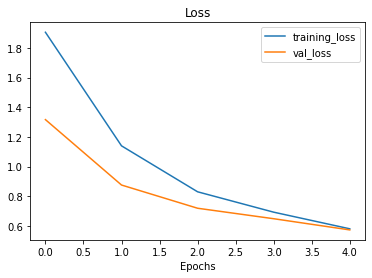

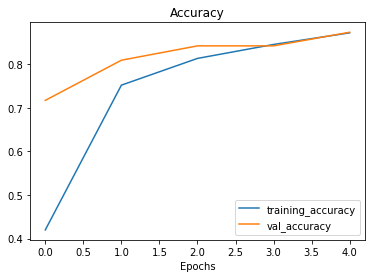

In [17]:
# Plot model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model.

- A Feature vector is a learned representation of the input data(a compressed form of the input data based on how the model sees it).

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)
# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")
# Pass the random tensor through Global Average Pooling 2D Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [19]:
# Replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments.

1. `model_1` - Use Feature Extraction Transfer Learning with 1% of training data with data augmentation.
2. `model_2` - Use Feature Extraction Transfer Learning with 10% of the training with data augmentation.
3. `model_3` - Use Fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - Use Fine-tuning transfer learning on 100% of the training data with data augmentation. 

## Getting and Preprocessing data for `model_1`

In [20]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-04-14 03:17:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   238MB/s    in 0.5s    

2022-04-14 03:17:01 (238 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Creating training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
# How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [23]:
# Setup data loaders 
IMG_SHAPE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent, 
                                                                           label_mode="categorical", 
                                                                           image_size=IMG_SIZE, 
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation as a layer into the model

To add data augmentation right into our models, we can use the layers inside:

- `tf.keras.layers.experimental.preprocessing()`

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
# Create data augmentation stage with horizontal flipping, rotations, zoms, etc.
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomZoom(0.2), 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2), 
  # preprocessing.Rescale(1./255)
], name="data_augmentation")

### Visualize data augmentation layer.

(-0.5, 444.5, 431.5, -0.5)

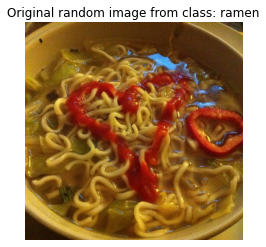

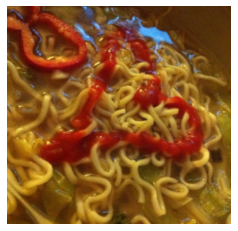

In [26]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Let's plot our Augmented Random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)

## Model 1: Feature Extraction Transfer Learning on 1% of the data with data augmentation.

In [27]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")
# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)
# Give base_model the inputs
x = base_model(x, training=False)
# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)
# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)
# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])
# Fit the model
history_1 = model_1.fit(train_data_1_percent, 
                        epochs=5, 
                        steps_per_epoch=len(train_data_1_percent), 
                        validation_data=test_data, 
                        validation_steps=int(0.25*len(test_data)), 
                        callbacks=[create_tensorboard_callback("transfer_learning", 
                                                               "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220414-031706
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4846 - accuracy: 0.0714 - val_loss: 2.2299 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.2071 - accuracy: 0.1571 - val_loss: 2.1194 - val_accuracy: 0.2270
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9984 - accuracy: 0.3571 - val_loss: 2.0216 - val_accuracy: 0.3240
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8359 - accuracy: 0.5429 - val_loss: 1.9135 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7222 - accuracy: 0.5286 - val_loss: 1.8298 - val_accuracy: 0.4424


In [28]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [29]:
# Evaluate on full test set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 1.8386 - accuracy: 0.4532


[1.8386386632919312, 0.45320001244544983]

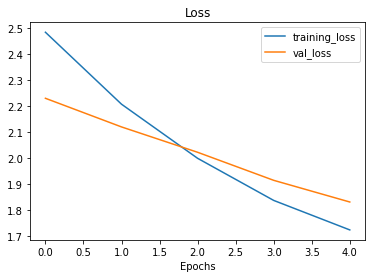

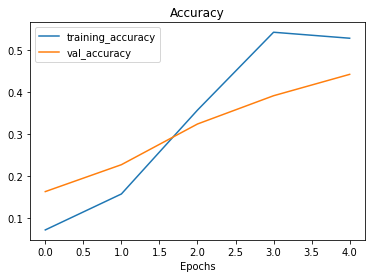

In [30]:
# Plot loss curves
plot_loss_curves(history_1)

## Model 2: Feature Extraction transfer learning model with 10% of data and data augmentation.

In [31]:
# Get 10% of data
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [32]:
# Setup the input shape to our model
input_shape = (224, 224, 3)
# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape, 
                      name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine inputs and outputs
model_2 = keras.Model(inputs, outputs)
# Compile
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

### Creating a callbacks

The ModelCheckpoint callback intermediately saves our model(the full model or just the weights) during training. This is useful so we can come and start off where we left off.

In [33]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
# Create a Model Checkpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, 
                                                         save_best_only=False, 
                                                         save_freq="epoch", 
                                                         verbose=1)

In [34]:
# Fit the model
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent, 
                        epochs=initial_epochs, 
                        validation_data=test_data, 
                        validation_steps=int(0.25*len(test_data)), 
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                               experiment_name="10_percent_data_aug"), 
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220414-031749
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9821 - accuracy: 0.3600
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 560ms/step - loss: 1.9821 - accuracy: 0.3600 - val_loss: 1.4567 - val_accuracy: 0.6678
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.6560
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 546ms/step - loss: 1.3559 - accuracy: 0.6560 - val_loss: 1.0580 - val_accuracy: 0.7516
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0320 - accuracy: 0.7520
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 394ms/step - loss: 1.0320 - accuracy: 0.7520 - val_loss: 0.8491 - val_accuracy: 0.8076
E

In [35]:
results_2 = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6855 - accuracy: 0.8104


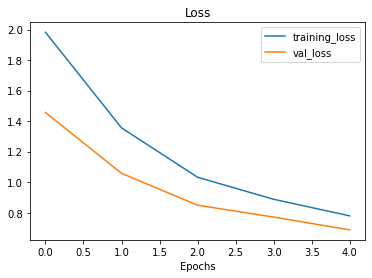

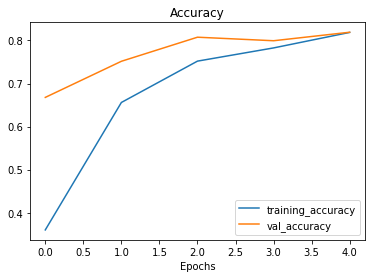

In [36]:
# Plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpoint weights

Loading in checkpoint weights returns a model to a specific checkpoint.

In [37]:
model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6855 - accuracy: 0.8104


In [39]:
# Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_2), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data.

- Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [40]:
# Layers in our loaded model
model_2.layers

In [41]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3dc9b8b690> True
<keras.engine.sequential.Sequential object at 0x7f3dc84ee790> True
<keras.engine.functional.Functional object at 0x7f3dc9619690> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3dc96835d0> True
<keras.layers.core.dense.Dense object at 0x7f3dc9701810> True


In [42]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [43]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [44]:
# To begin fine-tuning, let's start by setting last 10 layers of our base model, true
base_model.trainable = True
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile our model
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
# Check which layers are trainable
for layer_number, layers in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 block7a_activation False
1 block7a_activation False
2 block7a_activation False
3 block7a_activation False
4 block7a_activation False
5 block7a_activation False
6 block7a_activation False
7 block7a_activation False
8 block7a_activation False
9 block7a_activation False
10 block7a_activation False
11 block7a_activation False
12 block7a_activation False
13 block7a_activation False
14 block7a_activation False
15 block7a_activation False
16 block7a_activation False
17 block7a_activation False
18 block7a_activation False
19 block7a_activation False
20 block7a_activation False
21 block7a_activation False
22 block7a_activation False
23 block7a_activation False
24 block7a_activation False
25 block7a_activation False
26 block7a_activation False
27 block7a_activation False
28 block7a_activation False
29 block7a_activation False
30 block7a_activation False
31 block7a_activation False
32 block7a_activation False
33 block7a_activation False
34 block7a_activation False
35 block7a_activation False
36

In [46]:
print(len(model_2.trainable_variables))

12


In [47]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5
# Refit the model
history_2b = model_2.fit(train_data_10_percent, 
                         epochs=fine_tune_epochs, 
                         validation_data=test_data, 
                         validation_steps=int(0.25*len(test_data)), 
                         initial_epoch=history_2.epoch[-1], 
                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",                                                                 
                                                                experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220414-032407
Epoch 5/10
24/24 [==============================] - 20s 465ms/step - loss: 0.6678 - accuracy: 0.8120 - val_loss: 0.5565 - val_accuracy: 0.8141
Epoch 6/10
24/24 [==============================] - 9s 359ms/step - loss: 0.5355 - accuracy: 0.8307 - val_loss: 0.5225 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 8s 317ms/step - loss: 0.4737 - accuracy: 0.8680 - val_loss: 0.5102 - val_accuracy: 0.8174
Epoch 8/10
24/24 [==============================] - 8s 332ms/step - loss: 0.4408 - accuracy: 0.8613 - val_loss: 0.5639 - val_accuracy: 0.8010
Epoch 9/10
24/24 [==============================] - 8s 340ms/step - loss: 0.3960 - accuracy: 0.8787 - val_loss: 0.5543 - val_accuracy: 0.8125
Epoch 10/10
24/24 [==============================] - 9s 343ms/step - loss: 0.3474 - accuracy: 0.9040 - val_loss: 0.5453 - val_accuracy: 0.8224


In [48]:
results_2b = model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.5036 - accuracy: 0.8328


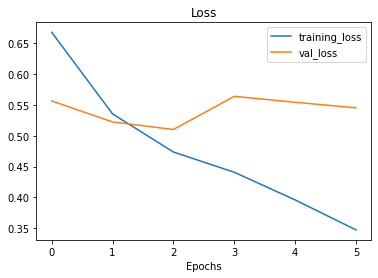

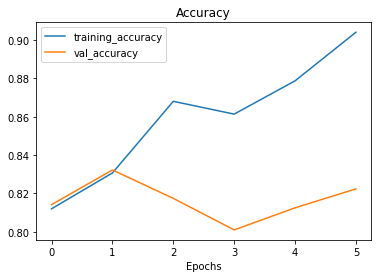

In [49]:
plot_loss_curves(history_2b)

- The `plot_loss_curve` function works great for models which have only been fit once, however we want something to compare one series of running `fit()` with another.

In [54]:
# Create a function to compare training history.
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compare two TensorFlow History objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make Plots for accuracy
  plt.figure(figsize=(10, 7))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  # Make Plots for loss
  plt.figure(figsize=(10, 7))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")

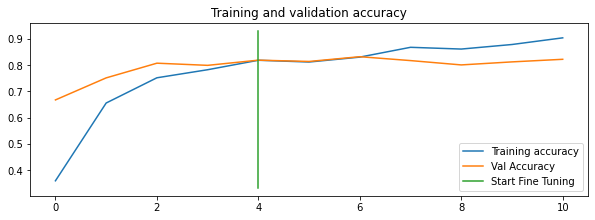

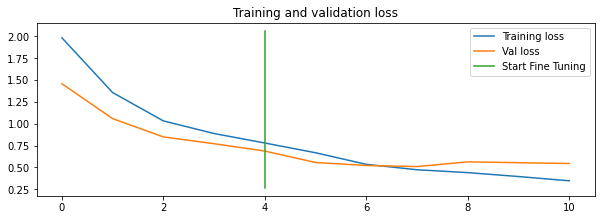

In [55]:
compare_history(history_2, history_2b)

## Model 4: Fine-tuning an existing model on 100% training data.

In [56]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-04-14 03:59:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.45.112, 142.250.81.208, 142.250.188.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.45.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   261MB/s    in 1.9s    

2022-04-14 04:00:00 (261 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [60]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [58]:
# How many images are we working
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [61]:
# Setup data inputs
train_data_10_classes_full = keras.preprocessing.image_dataset_from_directory(train_dir_all_data, 
                                                                              label_mode="categorical", 
                                                                              image_size=IMG_SIZE, 
                                                                              )
test_data = keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                             label_mode="categorical", 
                                                             image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [62]:
# Load weights from checkpoint, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [63]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [64]:
# Let's drill into our base model to check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [65]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

In [68]:
# Fit the model
history_3 = model_2.fit(train_data_10_classes_full, 
                        epochs=fine_tune_epochs, 
                        validation_data=test_data, 
                        validation_steps=int(0.25*len(test_data)), 
                        initial_epoch=history_2.epoch[-1], 
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                               experiment_name="full_10_classes_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20220414-041903
Epoch 5/10
235/235 [==============================] - 49s 204ms/step - loss: 0.5925 - accuracy: 0.8127 - val_loss: 0.3726 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 42s 178ms/step - loss: 0.5192 - accuracy: 0.8331 - val_loss: 0.3720 - val_accuracy: 0.8651
Epoch 7/10
235/235 [==============================] - 40s 168ms/step - loss: 0.4797 - accuracy: 0.8480 - val_loss: 0.3650 - val_accuracy: 0.8701
Epoch 8/10
235/235 [==============================] - 36s 152ms/step - loss: 0.4434 - accuracy: 0.8587 - val_loss: 0.3283 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 37s 154ms/step - loss: 0.4112 - accuracy: 0.8704 - val_loss: 0.3419 - val_accuracy: 0.8882
Epoch 10/10
235/235 [==============================] - 35s 147ms/step - loss: 0.3833 - accuracy: 0.8777 - val_loss: 0.2940 - val_accuracy: 0.9030


In [69]:
# Evaluate on all of data set
results_3 = model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.2887 - accuracy: 0.9036


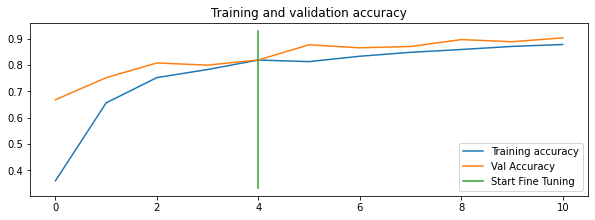

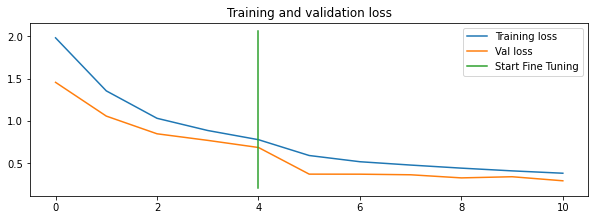

In [71]:
# How did fine-tuning go with more data?
compare_history(history_2, 
                history_3)

# View Experiments on TensorBoard

In [72]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amount of data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=xHI8d97R0414d3XYjSXBkLVqc2MeK3&prompt=consent&access_type=o

In [73]:
!tensorboard dev list

https://tensorboard.dev/experiment/4aSja2uMQd2Kivdli3SADg/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data
	Id                   4aSja2uMQd2Kivdli3SADg
	Created              2022-04-14 04:46:58 (3 minutes ago)
	Updated              2022-04-14 04:47:04 (3 minutes ago)
	Runs                 11
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  5186189
Total: 1 experiment(s)
